# Set up experiment detail 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
p = 100 # Number of dimensions
c = 1 # Target meanshift is c * M
k = 50 # Number of failuer Mode
nrun_IC = 5 # Number of runs
nrun_OC = 5
n_batch_phase1 = 5 # Number of batches for Phase 1
n_batch_phase2 = 5 # Number of batches for Phase 2
seed_list_IC = np.arange(nrun_IC) # Seeds for number of runs 
seed_list_OC = np.arange(1230,1230+nrun_OC) # 
num_failures = 3
M = np.kron(np.eye(k),np.ones((int(p/k),1))) # Mean Failure Modes
Ks = 5   #Select Top Ks control chart
nsensors = 5 # Number of selected sensors
ARL0 = 50 # Target ARL-IC
Tmax = 1000 # Maximum length

In [2]:
def data_gen_func0(n_batch, Tmax, seed):
    # Generate normal samples
    np.random.seed(seed)    
    data = np.random.randn(n_batch,Tmax,p)
    return data

def data_gen_func1(n_batch, Tmax, seed, T0, delta):
    # Generate abnormal samples
    np.random.seed(seed)
    sel_failure_mode = np.random.choice(k, num_failures)
    D1 = np.random.randn(n_batch, Tmax, p)
    shift = np.sum(M[:,sel_failure_mode]*delta,1)
    D1[:,T0:,:] = D1[:,T0:,:]+shift.reshape(1,1,p)
    return D1

In [3]:
from ExtendedTSSRP import ExtendedTSSRP
from MSSRP import MSSRP
from TSSRP import TSSRP
from spc.spc import spc
import time
truesensidx = np.arange(nsensors)
nmodels = 3
model_all = [[] for i in range(nmodels)]
spc_model_all = [[] for i in range(nmodels)]
model_name = ['E_srp_T2','E_srp_T1_Max','srp_M']
L = np.zeros(nmodels)

In [ ]:
# delta_all =  [0,0.2,0.4,0.6,0.8,1,1.2,1.5,1.8,2,3,4]
delta_all =  [0.4,0.8,1,1.5,2,3,4]
lendelta = len(delta_all)
start = time.time()
ARL_all = np.zeros((nmodels,lendelta))
mode_list = ['T2','T1_Max','M']
for j,jdelta in enumerate(delta_all):
    print(jdelta)
    for i in range(nmodels): 
        print(model_name[i], flush=True)    
        if i <=1:
            model_all[i] = ExtendedTSSRP(p, jdelta, k, M, nsensors, Ks, L=-1, chart = 'srp',mode=mode_list[i])
        else:
            model_all[i] = MSSRP(p, jdelta, k, M, nsensors, Ks, L=-1, chart = 'srp',mode='T2')
        monitor_statistics = lambda x, T0, L: model_all[i].compute_monitor_batch(x,T0, L)
        spc_model_all[i] = spc(monitor_statistics,data_gen_func0, data_gen_func1)
        L[i] = spc_model_all[i].phase1(n_batch_phase1, Tmax, seed_list_IC,r=1000,ARL0=ARL0)
        
        T_all, RL = spc_model_all[i].phase2( n_batch_phase2, Tmax, seed_list_OC, 20, delta=jdelta)
        ARL_all[i,j] = np.mean(RL)
        print(ARL_all[i,j], flush=True)
# experiment_log['ARL1'] = ARL_all
end = time.time()
print(end -start)

0.4
E_srp_T2
14.96
E_srp_T1_Max
31.32
srp_M
32.6
0.8
E_srp_T2


In [ ]:
np.save('ARL_all', ARL_all)

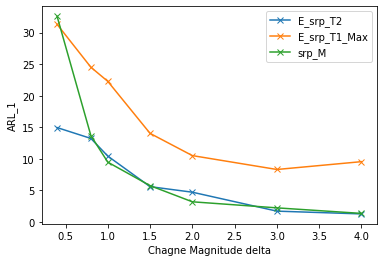

In [7]:
import numpy as np
import pickle
model_name = ['E_srp_T2','E_srp_T1_Max','srp_M']
for i in [0,1,2]:
    plt.plot(delta_all,ARL_all[i,:],'x-',label=model_name[i])
    plt.xlabel('Chagne Magnitude delta')
    plt.ylabel('ARL_1')
    plt.legend()